## CIFAR-10 

In [0]:
!pip install talos

In [0]:
import os
import talos as ta
from talos import live
import tensorflow as tf
from talos import Evaluate

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [0]:
def cifar10_fn(x_train, y_train, x_val, y_val, params):
    
    conv_dropout = float(params['conv_dropout'])
    dense1_neuron = int(params['dense1_neuron'])
    model = Sequential()
    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (5, 5), padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(conv_dropout))

    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(128, (5, 5), padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(conv_dropout))

    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(256, (5, 5), padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(conv_dropout))

    model.add(Flatten())
    model.add(Dense(dense1_neuron))
    model.add(Activation(params['activation']))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
  
    model.compile(
        optimizer=params['optimizer'],
        loss=params['loss'],
        metrics=['accuracy']
    )

    out = model.fit(
        x_train, 
        y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=1,
        validation_data=[x_val, y_val],
        callbacks=[live()]
    )
    
    return out, model

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
x_train = x_train/255.0
x_test = x_test/255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

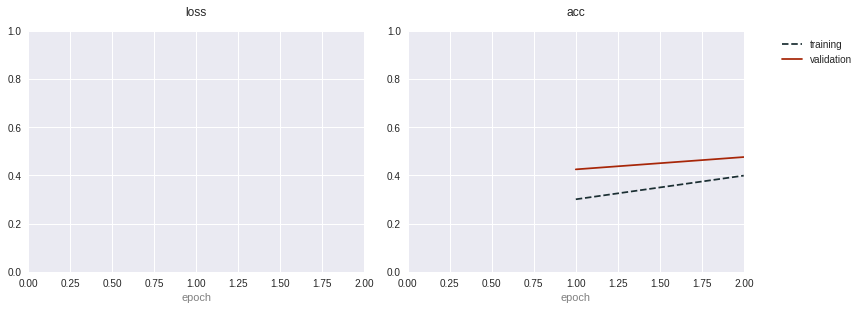

In [28]:
# for testing used simple parameters' values
'''para = {
    'epochs': [2],
    'batch_size': [128],
    'dense1_neuron': [128],
    'activation': ['relu', 'elu'],
    'optimizer': ['sgd'],
    'loss': ['categorical_crossentropy'],
    'conv_dropout': [0.2]
}'''


para = {
    'epochs': [10, 20],
    'batch_size': [32, 64, 128],
    'dense1_neuron': [128, 256, 512],
    'activation': ['relu', 'elu'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'loss': ['categorical_crossentropy'],
    'conv_dropout': [0.2, 0.3, 0.4, 0.5]
}

scan_results = ta.Scan(x_train,
                       y_train,
                       params=para,
                       model=cifar10_fn,
                       print_params=True,
                       reduce_loss=True,
                       debug=True,
                       disable_progress_bar=True)

In [29]:
# print summary
scan_results.details

complete_time              03/16/19/22:17
experiment_name             031619221559_
grid_downsample                      None
random_method            uniform_mersenne
reduce_loss                          True
reduction_interval                     50
reduction_method                     None
reduction_metric                  val_acc
reduction_threshold                   0.2
reduction_window                       20
x_shape                (50000, 32, 32, 3)
y_shape                       (50000, 10)
dtype: object

In [0]:
report = ta.Reporting(scan_results)

# use filename to store experiemnt log
# r = ta.Reporting('iris_1.csv')

In [31]:
# get the best paramaters
report.best_params()

array([['elu', 'sgd', '0.2', '128', '2', '128', 0],
       ['relu', 'sgd', '0.2', '128', '2', '128', 1]], dtype=object)

In [39]:
evalModel = Evaluate(scan_results)
# Got an error for 'average' attribute
# evalModel.evaluate(x_test, y_test, folds=10, average='macro', shuffle=True)
evalModel.evaluate(x_test, y_test, folds=10, shuffle=True)

[0.444542960380881,
 0.47515784308750747,
 0.4837887034634692,
 0.4885104837211176,
 0.49151442605895285,
 0.4709308785958889,
 0.4755284834296532,
 0.47780019169704147,
 0.4681855476049467,
 0.4646048892059086]

## Using for TPU session

In [0]:
def cifar10_fn(x_train, y_train, x_val, y_val, params):
	# Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    conv_dropout = float(params['conv_dropout'])
    dense1_neuron = int(params['dense1_neuron'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation=params['activation']))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(conv_dropout))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation=params['activation']))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(conv_dropout))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation=params['activation']))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(conv_dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(params['dense1_neuron']))
    model.add(tf.keras.layers.Activation(params['activation']))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))
    
    # Step 3: conver the model to tpu model and compile with tensorflow optimizer.
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )
    tpu_model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['categorical_accuracy']
    )

    # Step 4: Train the model on TPU with fixed batch size.
    out = tpu_model.fit(
        x_train, y_train, epochs=10, batch_size = 1024,
        verbose=0,
        validation_data=[x_val, y_val]
    )
    # Step 5: Return the history output and synced back cpu model.
    return out, tpu_model.sync_to_cpu()

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [0]:
x_train = x_train/255.0
x_test = x_test/255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# for testing used simple parameters' values
'''para = {
    'epochs': [2],
    'batch_size': [128],
    'dense1_neuron': [128],
    'activation': ['relu', 'elu'],
    'optimizer': ['sgd'],
    'loss': ['categorical_crossentropy'],
    'conv_dropout': [0.2]
}'''


para = {
    'epochs': [10, 20],
    'batch_size': [32, 64, 128],
    'dense1_neuron': [128, 256, 512],
    'activation': ['relu', 'elu'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'loss': ['categorical_crossentropy'],
    'conv_dropout': [0.2, 0.3, 0.4, 0.5]
}

scan_results = ta.Scan(x_train,
                       y_train,
                       params=para,
                       model=cifar10_fn,
                       print_params=True,
                       reduce_loss=True,
                       debug=True,
                       disable_progress_bar=True)

In [0]:
# print summary
scan_results.details

In [0]:
report = ta.Reporting(scan_results)

# use filename to store experiemnt log
# r = ta.Reporting('iris_1.csv')

In [0]:
# get the best paramaters
report.best_params()

In [0]:
evalModel = Evaluate(scan_results)
# Got an error for 'average' attribute
# evalModel.evaluate(x_test, y_test, folds=10, average='macro', shuffle=True)
evalModel.evaluate(x_test, y_test, folds=10, shuffle=True)

In [0]:
# Get the best model index with highest 'val_categorical_accuracy' 
model_id = scan_results.data['val_categorical_accuracy'].astype('float').argmax() - 1

# Clear any previous TensorFlow session.
tf.keras.backend.clear_session()